In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

\begin{equation}
    null\_score \sim U(0, 1)
\end{equation}

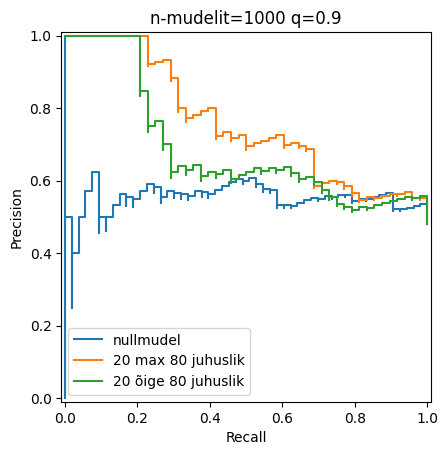

In [9]:
n_samples = 100
n_models = 1000
quantile = 0.9
tenth = int(n_samples / 10)
shuffle = np.random.permutation(n_samples)

_, ax = plt.subplots()
ax.set_title(f"n-mudelit={n_models} q={quantile}")

y_juhuslik = np.random.binomial(n=1, p=0.5, size=n_samples)
# todo: see on ilmselt vale, sest labelid ei ole juhuslikud, samas keskväärtus peaks sama olema, mis y
y_biased = np.concat((np.zeros(tenth), np.ones(tenth), np.random.binomial(n=1, p=0.5, size=tenth * 8)))[shuffle]

# juhuslik
null_scores = [np.random.uniform(size=n_samples) for _ in range(n_models)]
null_score_q = np.quantile(null_scores, quantile, axis=0)

precision, recall, _ = precision_recall_curve(y_juhuslik, y_score=null_score_q)
display = PrecisionRecallDisplay(precision, recall)
display.plot(ax=ax, name=f"nullmudel")

# 20/80 max/juhuslik
biased_max_gen = lambda: np.concat((np.zeros(tenth), np.ones(tenth), np.random.uniform(size=tenth * 8)))[shuffle]
biased_max_scores = [biased_max_gen() for _ in range(n_models)]
biased_max_score_q = np.quantile(biased_max_scores, quantile, axis=0)

precision, recall, _ = precision_recall_curve(y_biased, y_score=biased_max_score_q)
display = PrecisionRecallDisplay(precision, recall)
display.plot(ax=ax, name=f"20 max 80 juhuslik")

# 20/80 õige/juhuslik
biased_gen = lambda: np.concat((np.random.uniform(low=0.0, high=0.5, size=tenth),
                                np.random.uniform(low=0.5 + 1e-6, high=1.0, size=tenth),
                                np.random.uniform(size=tenth * 8)))[shuffle]
biased_scores = [biased_gen() for _ in range(n_models)]
biased_score_q = np.quantile(biased_scores, quantile, axis=0)

precision, recall, _ = precision_recall_curve(y_biased, y_score=biased_score_q)
display = PrecisionRecallDisplay(precision, recall)
display.plot(ax=ax, name=f"20 õige 80 juhuslik")